# Análisis de Rentas Residenciales en la Ciudad de México

La búsqueda de un departamento en la Ciudad de México suele ser una tarea compleja. Determinar si el precio de una renta es adecuado, subvalorado o sobrevalorado con respecto al promedio de la zona donde deseamos vivir, es una valoración que frecuentemente realizamos de manera intuitiva, basándonos en percepciones personales o en la opinión de amigos y familiares; es decir, "a ojo de buen cubero".

El objetivo de este notebook es analizar datos de departamentos en renta, extraídos de diversas fuentes de internet, para identificar y visualizar los rangos de precios predominantes en distintas alcaldías de la Ciudad de México.

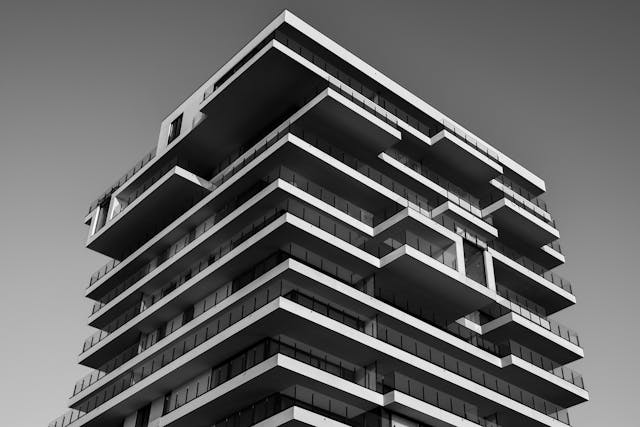

# Obtención de datos
Los datos utilizados en este estudio fueron obtenidos de fuentes inmobiliarias digitales. Se aseguró que el proceso de extracción cumpliera con todos los lineamientos legales y éticos, incluyendo el respeto a los robots.txt de los sitios y los términos de servicio de las plataformas proveedoras de información.


## Limpieza de Datos
Iniciamos el proceso de limpieza importando el conjunto de datos. El objetivo es preparar la información para un análisis más preciso, lo que implica:

- Eliminar los registros con valores nulos en columnas críticas como "Precio", "m2 cuadrados de construcción" y "Colonia", ya que son esenciales para nuestro análisis.
- Asegurar el formato correcto para los valores de cada columna (ej. numérico para precios y superficies, texto para nombres de colonias).
- Generar un dataset base limpio, que servirá como punto de partida para aplicar los filtros específicos requeridos en las siguientes etapas del análisis.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Cargamos los datos
df_renta = pd.read_csv('inmuebles_renta.csv', parse_dates=['fecha_captura'])

In [20]:
# Eliminar filas con valores faltantes en columnas importantes y duplicados
df_limpio = df_renta.dropna(subset=['Precio', 'm2 de construcción', 'Colonia', 'Delegación'])
df_limpio = df_limpio.drop_duplicates()

# Limpiar columnas
df_limpio['Precio'] = df_limpio['Precio'].str.replace(',', '')
df_limpio['Precio'] = df_limpio['Precio'].str.replace('$', '')
df_limpio['Precio'] = df_limpio['Precio'].str.replace('MXN', '')
df_limpio['Precio'] = df_limpio['Precio'].str.replace(' ', '').astype(int)



<ipython-input-20-99f562ebac13>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_limpio['Precio'] = df_limpio['Precio'].str.replace('$', '')


In [21]:
#Obtenemos una vista previa de los datos
df_limpio.head()

,id,Tipo de inmueble,Operación,Precio,Estado,Delegación,Colonia,Núm. de recamaras,Núm. de baños,Estacionamientos,m2 de construcción,m2 de terreno,Niveles,Antigüedad,fecha_captura
0,64699tc,DEPARTAMENTO,RENTA,16800,CDMX,COYOACAN,Paseos De TaxqueÑa,2.0,2,2.0,97.0,NaN,6.0,MAS DE 30,2025-05-16 01:26:02
1,64973tc,LOCAL COMERCIAL,RENTA,10000,CDMX,TLALPAN,Pedregal Del Lago,NaN,SI,NaN,33.0,NaN,NaN,NaN,2025-05-16 01:26:05
2,64981tc,DEPARTAMENTO,RENTA,7000,CDMX,CUAUHTEMOC,Doctores,2.0,1,NaN,45.0,NaN,3.0,MAS DE 30,2025-05-16 01:26:08
3,64929tc,CASA DUPLEX,RENTA,15000,CDMX,TLALPAN,Villa Coapa,2.0,1,NaN,75.0,NaN,1.0,MAS DE 30,2025-05-16 01:26:12
4,64930tc,CASA,RENTA,28000,CDMX,IZTAPALAPA,El Prado,3.0,2,2.0,137.0,NaN,1.0,ENTRE 21 - 30 AÑOS,2025-05-16 01:26:15


# Verificación de Cobertura Geográfica por Estado

En este paso, examinamos el *dataset* para determinar los estados presentes en nuestros registros de rentas. Posteriormente, aplicaremos un filtro para seleccionar únicamente los datos correspondientes a departamentos en la Ciudad de México, que es el foco de nuestro estudio.

In [22]:
# Revisamos los estados que tenemos en los datos
df_limpio[['Operación','Estado']].value_counts()

Operación  Estado 
RENTA      CDMX       456
           EDOMEX      23
           PUEBLA      11
           JALISCO      4
dtype: int64

In [23]:
#Limpiamos los datos para obtener solo los departamentos en renta de la CDMX
df_limpio_cdmx = df_limpio[(df_limpio['Estado'] == 'CDMX') & (df_limpio['Tipo de inmueble'] == 'DEPARTAMENTO')]
df_limpio_cdmx[['Estado','Tipo de inmueble']].value_counts()

Estado  Tipo de inmueble
CDMX    DEPARTAMENTO        232
dtype: int64

# Análisis Exploratorio de Datos

## Distribución de las Rentas en CDMX: Identificación de Sesgo

En esta sección, se examina la distribución de los precios de renta. Si bien la concentración principal de los datos podría sugerir una forma similar a la normal, se identifica un claro sesgo hacia la derecha (*right-skewed*). Esta característica es indicativa de la influencia de valores atípicos, es decir, rentas excepcionalmente altas que distorsionan la simetría de la distribución.

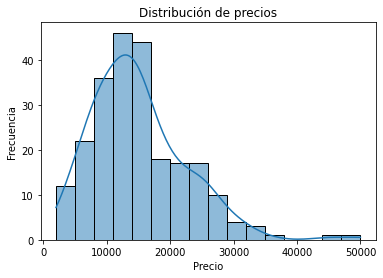

In [24]:
#Distribución de precios
sns.histplot(data=df_limpio_cdmx, x='Precio', kde=True)
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

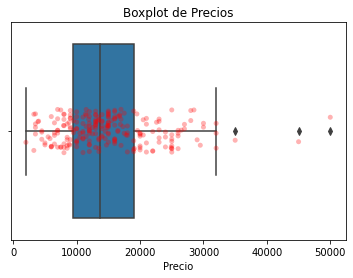

In [25]:
# Boxplot para ver los cuartiles y valores atípicos
sns.boxplot(data=df_limpio_cdmx, x='Precio')
sns.stripplot(data=df_limpio_cdmx, x='Precio', color='red', alpha=0.3)
plt.title('Boxplot de Precios')
plt.xlabel('Precio')
plt.show()

## Análisis de Valores Atípicos en las Rentas

Una característica notable de nuestros datos de rentas en la CDMX es la presencia de valores atípicos: un pequeño porcentaje de departamentos con precios de renta considerablemente superiores al resto. Esta particularidad afecta la interpretación de la distribución general y las métricas descriptivas.

Para dimensionar su impacto, comparamos:
- **Mediana**:
    $13,750.00 (representa el valor central, menos sensible a extremos)
- **Promedio**:
    $14,913.15 (afectado por los valores altos)

Como se evidencia, el promedio es notablemente mayor que la mediana. Esto confirma que los valores atípicos (rentas muy altas) están "tirando" del promedio hacia arriba, lo que resulta en una distorsión de los datos y provoca el pronunciado sesgo hacia la derecha en la distribución. A continuación, se evaluará cómo abordar estos valores para análisis subsecuentes.

In [26]:
mediana = df_limpio_cdmx['Precio'].median()
promedio = df_limpio_cdmx['Precio'].mean()
print(f'La mediana es: {mediana:,.2f}')
print(f'El promedio es: {promedio:,.2f}')
print(f'Los valores atípicos hacen distorsionan los datos generando un sesgo importante, en este caso hacia la derecha')

La mediana es: 13,750.00
El promedio es: 14,913.15
Los valores atípicos hacen distorsionan los datos generando un sesgo importante, en este caso hacia la derecha


## ¿Cuáles son los Departamentos Atípicos?
A continuación se muestra un dataset con los valores atípicos

In [27]:
# Regla empírica
limite_inferior = df_limpio_cdmx['Precio'].median() - (2 * df_limpio_cdmx['Precio'].std())
limite_superior = df_limpio_cdmx['Precio'].median() + (2 * df_limpio_cdmx['Precio'].std())

# Filtrar los departamentos que están por encima del límite superior
departamentos_atipicos = df_limpio_cdmx[df_limpio_cdmx['Precio'] > limite_superior]
print(f'El 95% de las rentas están entre {abs(limite_inferior):,.0f} y {limite_superior:,.0f}')
print(f'Los departamentos atípicos que están por encima del límite superior son: {departamentos_atipicos.shape[0]}')
departamentos_atipicos[['Tipo de inmueble', 'Operación', 'Precio', 'Delegación', 'Colonia', 'm2 de construcción']].head()


El 95% de las rentas están entre 1,098 y 28,598
Los departamentos atípicos que están por encima del límite superior son: 10


,Tipo de inmueble,Operación,Precio,Delegación,Colonia,m2 de construcción
51,DEPARTAMENTO,RENTA,35000,BENITO JUAREZ,San Jose Insurgentes,160.0
128,DEPARTAMENTO,RENTA,29500,CUAUHTEMOC,Cuauhtemoc,120.0
129,DEPARTAMENTO,RENTA,29000,ALVARO OBREGON,Las Aguilas,143.0
183,DEPARTAMENTO,RENTA,45000,BENITO JUAREZ,Del Valle Centro,240.0
252,DEPARTAMENTO,RENTA,30000,BENITO JUAREZ,Del Valle Sur,90.0


Al analizar la distribución de precios, se observa que el 95% de las rentas se encuentran en un rango de \$1,098 a \$28,598.

Es importante destacar que el límite inferior de este rango (\$1,098) podría indicar la inclusión de rentas de habitaciones individuales en lugar de departamentos completos. Esta posibilidad amerita una revisión más detallada de los datos para asegurar la correcta categorización de las propiedades.

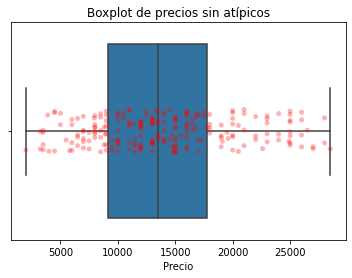

In [28]:
#Boxplot sin atípocos
df_limpio_cdmx_sin_atipicos = df_limpio_cdmx[df_limpio_cdmx['Precio'] <= limite_superior]
sns.boxplot(data=df_limpio_cdmx_sin_atipicos, x='Precio')
sns.stripplot(data=df_limpio_cdmx_sin_atipicos, x='Precio', color='red', alpha=0.3)
plt.title('Boxplot de precios sin atípicos')
plt.xlabel('Precio')
plt.show()

# Principales Alcaldías por Número de Departamentos en Renta

Para el análisis, nos enfocaremos en las alcaldías con el mayor número de departamentos en renta registrados. Esta selección permite generar visualizaciones más robustas e informativas, ya que una mayor densidad de datos por alcaldía facilita la identificación de patrones claros.

In [29]:
top_5_colonias = df_limpio_cdmx_sin_atipicos['Delegación'].value_counts().nlargest(5).index.tolist()
df_top_5_colonias = df_limpio_cdmx_sin_atipicos[df_limpio_cdmx_sin_atipicos['Delegación'].isin(top_5_colonias)]
median_prices = df_top_5_colonias.groupby('Delegación')['Precio'].median()
ordered_colonias = median_prices.sort_values().index
delegation_counts_order = df_top_5_colonias['Delegación'].value_counts().index



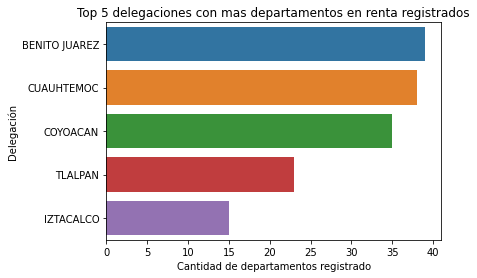

In [30]:
sns.countplot(data=df_top_5_colonias , y='Delegación', order=delegation_counts_order)
plt.title('Top 5 delegaciones con mas departamentos en renta registrados')
plt.ylabel('Delegación')
plt.xlabel('Cantidad de departamentos registrado')
plt.show()


## Promedio y Rango de Rentas por Alcaldía

En esta sección, se presenta un resumen estadístico de los costos de renta para las alcaldías analizadas. Se detallan el precio promedio, así como los valores máximos y mínimos registrados en cada una.

Es importante destacar dos observaciones principales de este análisis:
1.  **Presencia de valores atípicos intra-alcaldía:** Incluso dentro de demarcaciones específicas, se identifican rentas que se desvían considerablemente del promedio local.
2.  **Amplitud en los rangos de renta:** Algunas alcaldías muestran una dispersión notable en sus precios, con diferencias significativas entre los montos mínimos y máximos.

Estos hallazgos sugieren una heterogeneidad considerable en el mercado inmobiliario de dichas zonas e invitan a una exploración más profunda para comprender los factores que impulsan estas variaciones.

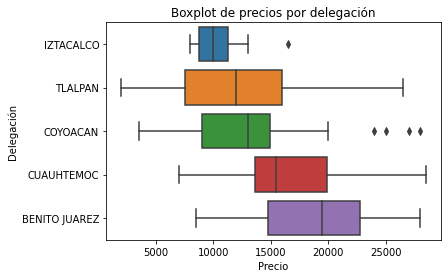

In [31]:
#Boxplot por delegaciones
sns.boxplot(data=df_top_5_colonias, y='Delegación', x='Precio', order=ordered_colonias)
plt.title('Boxplot de precios por delegación')
plt.ylabel('Delegación')
plt.xlabel('Precio')
plt.show()

## Correlación entre Precio y Metros Cuadrados

Al analizar la gráfica de dispersión, se observa una clara relación positiva entre el precio de renta y los metros cuadrados de los departamentos. Esto indica que, en términos generales, a mayor superficie, el precio de renta tiende a ser más alto.

No obstante, es importante destacar la presencia de valores atípicos (*outliers*). Algunos de estos puntos se desvían notablemente de la tendencia general:
* Ciertos departamentos ofrecen una gran cantidad de metros cuadrados a precios comparativamente bajos, lo que podría representar buenas oportunidades de renta.
* Otros, por el contrario, muestran precios elevados para una superficie reducida en comparación con la norma, sugiriendo un costo por metro cuadrado menos favorable.

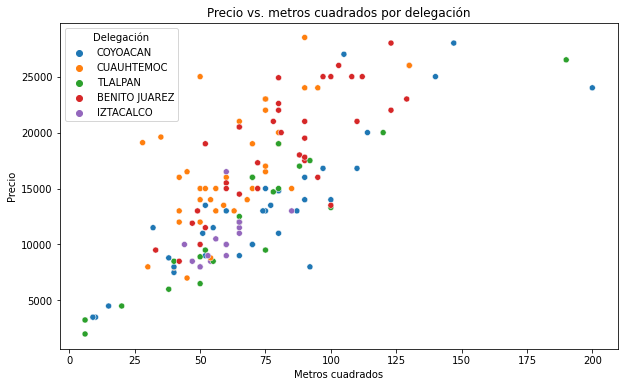

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='m2 de construcción', y='Precio', data=df_top_5_colonias, hue='Delegación')
plt.title('Precio vs. metros cuadrados por delegación')
plt.xlabel('Metros cuadrados')
plt.ylabel('Precio')
plt.show()

## ¿Cuál Delegación tiene en Promedio los Departamentos mas Grandes?

In [33]:
#Delegacion con departamentos mas grandes
df_top_5_colonias.groupby('Delegación')['m2 de construcción'].mean().sort_values(ascending=False)

Delegación
BENITO JUAREZ    81.179487
COYOACAN         73.742857
TLALPAN          65.043478
CUAUHTEMOC       62.447368
IZTACALCO        58.266667
Name: m2 de construcción, dtype: float64

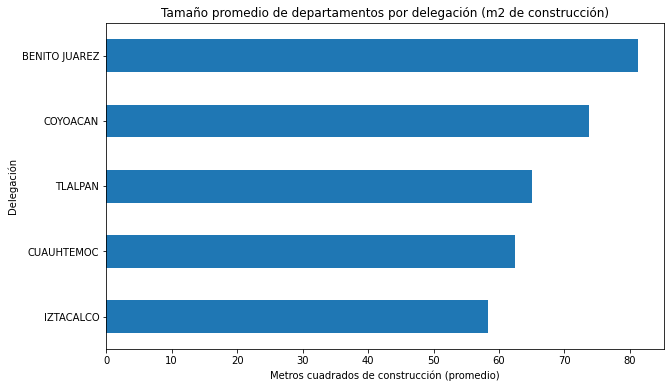

In [34]:
plt.figure(figsize=(10, 6))
df_top_5_colonias.groupby('Delegación')['m2 de construcción'].mean().sort_values(ascending=False).plot(kind='barh')
plt.title('Tamaño promedio de departamentos por delegación (m2 de construcción)')
plt.xlabel('Metros cuadrados de construcción (promedio)')
plt.ylabel('Delegación')
plt.gca().invert_yaxis()
plt.show()

# Conclusiones del Análisis de Rentas Residenciales en la Ciudad de México

Este análisis se propuso explorar los datos de departamentos en renta en la Ciudad de México para identificar rangos de precios y características relevantes en distintas alcaldías, partiendo de información extraída de fuentes inmobiliarias digitales.

Tras un proceso de limpieza que incluyó la eliminación de registros con valores nulos en columnas críticas como "Precio", "m2 cuadrados de construcción" y "Colonia", y la estandarización de formatos, el conjunto de datos se filtró para centrarse exclusivamente en departamentos en renta dentro de la CDMX, resultando en 232 registros para el análisis subsecuente.

Los principales hallazgos de la exploración de datos son los siguientes:

1.  **Distribución de Precios y Valores Atípicos:**
    * La distribución general de los precios de renta presenta un marcado sesgo hacia la derecha (*right-skewed*), lo que indica una concentración de departamentos en rangos de precios más bajos, pero con la presencia de propiedades con rentas significativamente más elevadas.
    * La mediana de los precios de renta se situó en \$13,750.00, mientras que el promedio fue de \$14,913.15. Esta diferencia confirma la influencia de los valores atípicos (rentas altas) que elevan la media.
    * Aplicando una regla empírica (mediana ± 2 desviaciones estándar), se determinó que aproximadamente el 95% de las rentas de departamentos se encuentran entre \$1,098 y \$28,598. Se identificaron 10 departamentos con precios superiores a este límite, considerados atípicos por su alto costo.
    * Se observó que el límite inferior de \$1,098 podría, en algunos casos, incluir rentas de habitaciones individuales en lugar de departamentos completos, lo cual sugiere un área para una revisión más detallada en futuras iteraciones del análisis para asegurar la correcta categorización de las propiedades.

2.  **Análisis por Alcaldía (Top 5 con más registros sin atípicos iniciales):**
    * Para un análisis más detallado y con visualizaciones robustas, se consideraron las 5 alcaldías con mayor número de departamentos registrados (excluyendo los valores atípicos de precio definidos previamente para este paso). Estas fueron: Benito Juárez, Cuauhtémoc, Álvaro Obregón, Coyoacán y Tlalpan.
    * El análisis de precios por alcaldía reveló la existencia de valores atípicos también a nivel local y rangos de precios considerablemente amplios dentro de algunas de ellas. Esto sugiere una notable heterogeneidad en el mercado inmobiliario incluso dentro de la misma demarcación, posiblemente debido a la diversidad de la oferta (tipos de acabados, antigüedad, servicios, etc.) o la influencia de microzonas con características y precios dispares.
    * En cuanto al tamaño promedio de los departamentos (m² de construcción) en estas alcaldías principales, Benito Juárez presenta, en promedio, los departamentos más grandes con aproximadamente 81 m², seguida por Coyoacán (aprox. 74 m²) y Álvaro Obregón (aprox. 72 m²). Tlalpan y Cuauhtémoc muestran un promedio de 65 m² y 62 m² respectivamente.

3.  **Correlación entre Precio y Metros Cuadrados:**
    * Se confirmó una relación positiva y clara entre el precio de renta y los metros cuadrados de los departamentos. Como es de esperar, a mayor superficie, el precio de renta tiende a ser más alto.
    * En la visualización de esta relación, también se identificaron valores atípicos: algunos departamentos ofrecen una mayor superficie a precios comparativamente bajos (potenciales oportunidades de renta), mientras que otros, con menor superficie, presentan precios elevados en relación con la tendencia general, lo que podría indicar propiedades sobrevaloradas o con características premium no capturadas únicamente por los metros cuadrados.

En resumen, el mercado de renta de departamentos en la Ciudad de México, basado en los datos analizados, es diverso y presenta una variabilidad de precios influenciada significativamente por la ubicación (alcaldía) y el tamaño del inmueble. La presencia de valores atípicos tanto a nivel general como dentro de las alcaldías subraya la necesidad de considerar múltiples factores al evaluar el costo de una renta. Futuros análisis podrían enriquecerse con la inclusión de más variables (como antigüedad del inmueble, amenidades, número de recámaras/baños de forma estandarizada) y una mayor cantidad de datos para refinar las estimaciones de rangos de precios y profundizar en las dinámicas específicas de cada alcaldía y colonia.